# A few notes on control invariant sets

This is a small notebook aimed to demonstrating some basic concepts for invariant sets, control invariant sets and N-step controllable sets. It uses the polytope package for convenience. As you can see from the code listings below, the computations are conceptually simple, and follow the recipes in the lecture notes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

from InvariantSets import *

# A basic example
We will consider the double integrator dynamics
\begin{align*}
    x_{t+1} &= \begin{pmatrix}
    1 & 1\\ 0 & 1
    \end{pmatrix}x_t + \begin{pmatrix}
    1/2\\ 1
    \end{pmatrix}u_t
\end{align*}
with a simple magnitude constraint on the control input, i.e. $\vert u_t\vert\leq 1$, and we would like all states to be less than 10 in magnitude. That is, we use the admissible set $X=\{ x \;\vert\; \Vert x\Vert_{\infty}\leq 10\}$. We will refer to the set of states that satisfy the state constraints as the admissible set.

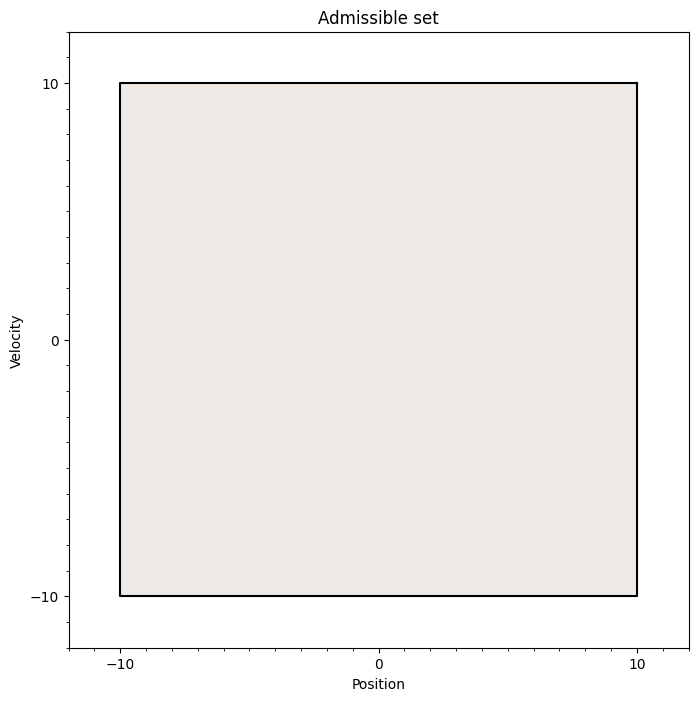

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Colors from the KTH palette
KTH_sand='#EBE5E0'
KTH_blue='#004791'
KTH_skyblue='#6298D2'
KTH_lightblue='#DEF0FF'
KTH_lightgray='#E6E6E6'
KTH_green='#4DA060'
KTH_yellow='#FFBE00'
KTH_brick='#E86A58'
KTH_darkbrick='#78001A'

# Define the A matrix
A_inf = np.array([
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1]
])

# Define the b vector
b_inf = np.array([10, 10, 10, 10])

# Create the polytope
admissible_set_polytope = Polytope(A_inf, b_inf)

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Create the figure and axes


# Plot the polytope with customized color, line style, and opacity
patch = admissible_set_polytope.plot(ax=ax, color=KTH_sand, edgecolor='black', linestyle='-', alpha=0.8)

# Set the limits of the axes to encompass the full polytope
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize the x and y axis ticks
ax = plt.gca()  # Get the current axis

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Admissible set')

# Display the plot
fig=plt.gcf()
plt.show()

# A useful control invariant set: the invariant set of the LQR controller
Note that the double integrator is not stable, so the only invariant set is the origin itself. We will therefore focus on control invariant sets. A useful control invariant set is the invariant set of some linear controller 
\begin{align*}
    u_t &= -Lx_t
\end{align*}
Since the controller is linear, it will only be able to operate in a restricted region without exceeding the saturation constraints. Hence, when we look for an invariant set for the closed loop dynamics
\begin{align*}
    x_{t+1} &= (A-BL)x_t
\end{align*}
we need to require that the states remains in intersection between the admissible set and the set where the controller does not saturate, i.e. 
\begin{align*}
    X \cap \{ x \;\vert\; \vert Lx\vert\leq 1\}
\end{align*}
Let's plot this set.

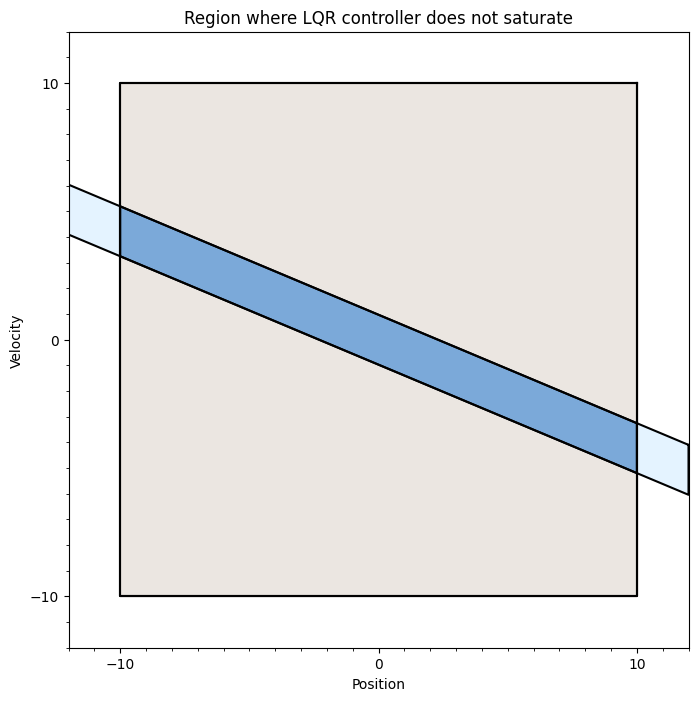

In [5]:
# Define the system matrices
A = np.array([[1, 1],
              [0, 1]])

B = np.array([[0.5],
              [1]])

# Define the cost matrices
Q = np.eye(2)  # State cost matrix (2x2 identity matrix)
R = np.array([[1]])  # Control cost (scalar as a 1x1 matrix)

# Solve the discrete-time LQR problem
L, P, E = ctrl.dlqr(A, B, Q, R)
L=np.asarray(L)

# Define the infinity norm ball polytope: ||x||_∞ <= 12 for bounding the strip
b_background = np.array([12, 12, 12, 12])
background_polytope = Polytope(A_inf, b_background)

# Define the polyhedron |Kx| <= 1
A_l = np.vstack([L, -L])  # Stack K and -K to handle the |Kx| <= 1
b_l = np.array([1, 1])  # Right-hand side of the inequality
L_polytope = Polytope(A_l, b_l)

# Intersect the strip |Kx| <= 1 with the infinity norm ball ||x||_∞ <= 12 to get a bounded region
LQR_not_saturated_polytope = L_polytope.intersect(background_polytope)

# Intersect this result with the original infinity norm ball ||x||_∞ <= 10
xadmissible_and_uadmissible_polytope = LQR_not_saturated_polytope.intersect(admissible_set_polytope)

# Plotting
plt.figure(fig)

# Plot the infinity-norm ball (||x||_∞ <= 10) first (bottom layer)
admissible_set_polytope.plot(ax=ax,color=KTH_sand, alpha=0.8, edgecolor='black')

# Plot the bounded |Kx| <= 1 strip intersected with the ball ||x||_∞ <= 12 (middle layer)
LQR_not_saturated_polytope.plot(ax=ax,color=KTH_lightblue, alpha=0.8, edgecolor='black')

# Plot the final intersection (top layer)
xadmissible_and_uadmissible_polytope.plot(ax=ax,color=KTH_skyblue, alpha=0.8, edgecolor='black')

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Region where LQR controller does not saturate')
plt.show()

We can now compute the invariant set of the closed-loop dynamics $x_{t+1}=(A-BL)x_t$ in this region (the one shown in the darker blue color)

Converged with determinedness index 1.



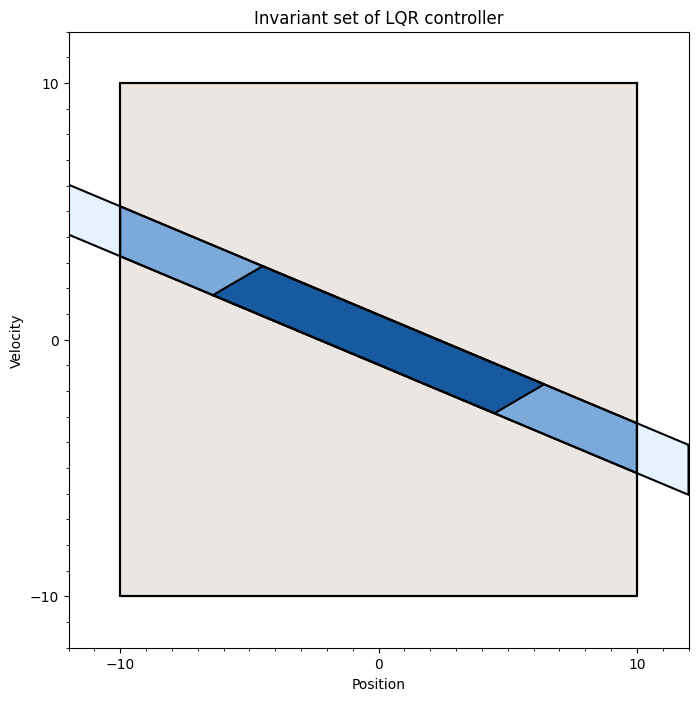

In [6]:
# Reuse the figure and axes created in the previous block
plt.figure(fig)  # Ensure you are referencing the correct figure

# Add the new set
myLQRSet = invariant_set(A - B @ L, xadmissible_and_uadmissible_polytope)  # Generate the new set
myLQRSet.plot(ax=ax, color=KTH_blue, alpha=0.8, edgecolor='black')
ax.set_title('Invariant set of LQR controller')
# Render the plot
plt.show()

Initial states that belong to the dark blue region in this plot will remain in this region and satisfy the state constraints for all future times, and the linear state feedback $u_t=-Lx_t$ will make it happen. Since the set is invariant for one possible control policy, it is control invariant. But it is typically not the largest possible control invariant set. We will compute the maximal one shortly. 

But first, it is useful to reflect on what happens to state outside of this region. First, if states are outside the yellow strip, the control policy that we consider violates the control constraints. There may be other control policies that can deal with these initial states, but the one that we have considered cannot do it. Inside the strip but outside the computed invariant set, the control law cannot keep the states inside the strip and inside the feasible set. 

The code below allows you to simulate different initial states, and see if it is the state or control constraints that break first. 

Initial state in invariant set.


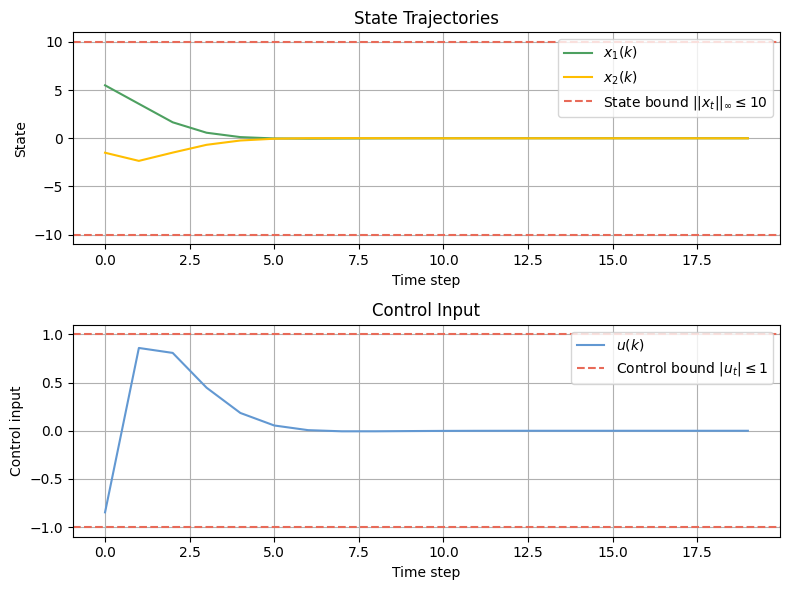

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
x0 = np.array([[5.5], [-1.5]])  # Initial state as a column vector (2D array) - change to verify invariance

if myLQRSet.contains(x0):
    print("Initial state in invariant set.")
else:
    print("Initial state outside of invariant set.")

num_steps = 20  # Number of time steps to simulate
ulim = 1  # Control limit

# Initialize arrays to store state and control inputs
x = np.zeros((2, num_steps))  # State history (2D array)
u = np.zeros(num_steps)       # Control input history

# Set the initial state
x[:, 0] = x0.flatten()  # Flatten x0 to 1D for compatibility with x[:, 0]

# Simulate the closed-loop system
for t in range(num_steps - 1):
    # Calculate control input using the feedback law u = -Lx
    u[t] = (-L @ x[:, t])[0]  # Extract the scalar value

    # Update state using the system dynamics x_{t+1} = Ax_t + Bu_t
    x[:, t + 1] = A @ x[:, t] + B.flatten() * u[t]

# Calculate the final control input for the last state
u[-1] = (-L @ x[:, -1])[0]  # Extract the scalar value for the final step

# Define constraints
state_constraint = 10  # Infinity-norm constraint for the state
control_constraint = ulim  # Control constraint

# Plot state trajectories and control signals
fig_sim, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot state trajectories
axs[0].plot(range(num_steps), x[0, :], label='$x_1(k)$', color=KTH_green)
axs[0].plot(range(num_steps), x[1, :], label='$x_2(k)$', color=KTH_yellow)
axs[0].axhline(state_constraint, color=KTH_brick, linestyle='--', label=r'State bound $||x_t||_∞ \leq 10$')
axs[0].axhline(-state_constraint, color=KTH_brick, linestyle='--')
axs[0].set_title('State Trajectories')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('State')
axs[0].legend()
axs[0].grid(True)

# Highlight violations of the state constraint
for t in range(num_steps):
    if np.max(np.abs(x[:, t])) > state_constraint:
        axs[0].plot(t, x[0, t], 'ro')  # Mark violation for x1
        axs[0].plot(t, x[1, t], 'ro')  # Mark violation for x2

# Plot control signal
axs[1].plot(range(num_steps), u, label='$u(k)$', color=KTH_skyblue)
axs[1].axhline(control_constraint, color=KTH_brick, linestyle='--', label=r'Control bound $|u_t| \leq 1$')
axs[1].axhline(-control_constraint, color=KTH_brick, linestyle='--')
axs[1].set_title('Control Input')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Control input')
axs[1].legend()
axs[1].grid(True)

# Highlight violations of the control constraint
for t in range(num_steps):
    if np.abs(u[t]) > control_constraint:
        axs[1].plot(t, u[t], 'ro')  # Mark control violation

plt.tight_layout()
plt.show()


# The maximal control invariant set
Let us now compute the maximal control invariant sets for the given system and control constraint, contained in the admissible set. 

Converged with determinedness index 6.



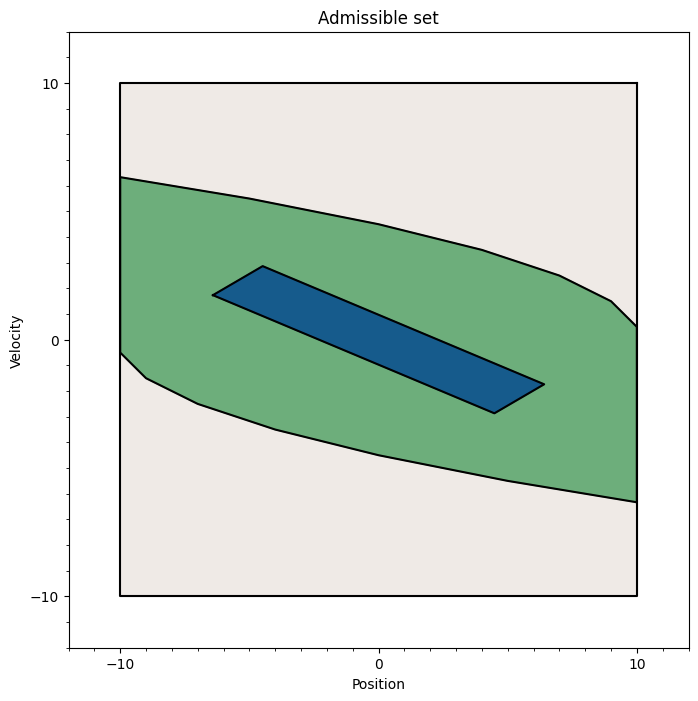

In [9]:

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Create the figure and axes

Cu=np.array([[1],[-1]])
cu=np.array([[1],[1]])
uCstrSet=Polytope(Cu,cu)
Cinf=control_invariant_set(A,B, admissible_set_polytope, uCstrSet)

# Plot the polytope with customized color, line style, and opacity
patch = admissible_set_polytope.plot(ax=ax, color=KTH_sand, edgecolor='black', linestyle='-', alpha=0.8)
Cinf.plot(ax=ax, color=KTH_green, alpha=0.8)
myLQRSet.plot(ax=ax, color=KTH_blue, alpha=0.8)

# Set the limits of the axes to encompass the full polytope
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize the x and y axis ticks
ax = plt.gca()  # Get the current axis

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Admissible set')

# Display the plot
fig=plt.gcf()
plt.show()

As we can see, the maximal control invariant set is substantially larger than the invariant set of the LQR controller for the given control constraints. One advantage of the invariant set of the LQR controller is that it is defined by relatively few inequalities for this system. This simplifies the implementation (a slightly smaller memory footping, and easier to solve quadratric program). Let us print out the inequalities of the maximal control invariant set and the invariant set of the LQR controller to see how many inequalities are involved.

In [10]:
print(Cinf)

Hyperplane representation of polytope
  [[ 0.10000   0.00000] |    [1.00000]
   [-0.10000   0.00000] |    [1.00000]
   [-0.09524  -0.09524] |    [1.00000]
   [-0.05556  -0.22222] |    [1.00000]
   [ 0.06897   0.20690] |    [1.00000]
   [ 0.09524   0.09524] |    [1.00000]
   [-0.08333  -0.16667] |    [1.00000]
   [-0.04444  -0.22222] |    [1.00000]
   [ 0.04444   0.22222] |    [1.00000]
   [ 0.05556   0.22222] |    [1.00000]
   [ 0.08333   0.16667] |    [1.00000]
   [-0.06897  -0.20690] |    [1.00000]
   [-0.03571  -0.21429] |    [1.00000]
   [ 0.03571   0.21429] x <= [1.00000]



In [11]:
print(myLQRSet)

Hyperplane representation of polytope
  [[ 0.43448   1.02847] |    [1.00000]
   [-0.43448  -1.02847] |    [1.00000]
   [ 0.10676  -0.18178] |    [1.00000]
   [-0.10676   0.18178] x <= [1.00000]



# The initial feasible set of the MPC controller
If we use the control invariant sets that we have computed in an MPC controller, then we require that the predicted states $T$ steps in the future belongs to this set. A smaller set will be more difficult to reach than a large one, resulting in a smaller set of states for which we can solve the planning problem. 

The set of states that can reach $X_T$ in $T$ steps is called the $T$-step reachable set of $X_T$ (under the given dynamics and constraints). We can compute using a technique that is quite similar to the one we used for the control invariant set. Let us see how the $T$ reachable set of the invariant set of the LQR controller depends on $T$. We begin by plotting the terminal set and the maximal control invariant set.

Converged with determinedness index 6.



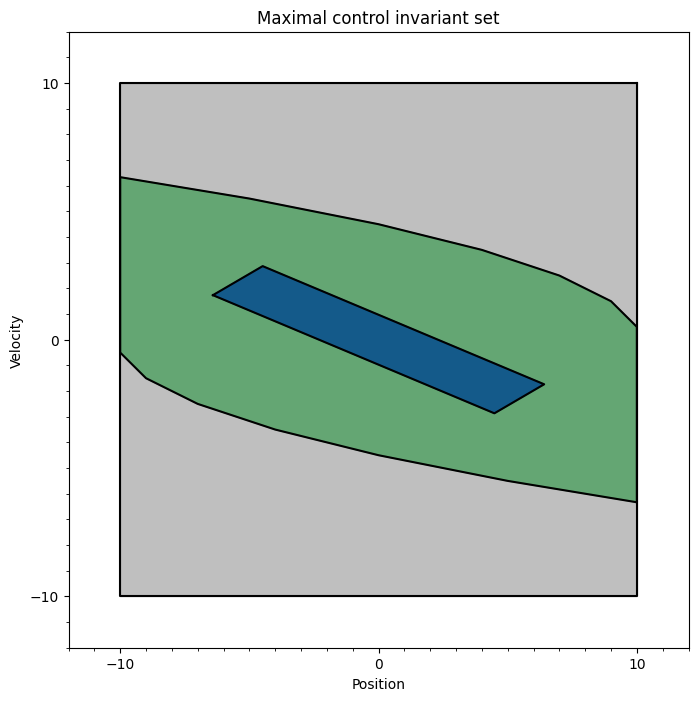

In [13]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Create the figure and axes


# Plot the polytope with customized color, line style, and opacity
patch = admissible_set_polytope.plot(ax=ax, color='gray', edgecolor='black', linestyle='-', alpha=0.5)

Cu=np.array([[1],[-1]])
cu=np.array([[1],[1]])
uCstrSet=Polytope(Cu,cu)
Cinf=control_invariant_set(A,B, admissible_set_polytope, uCstrSet)

Cinf.plot(ax=ax, color=KTH_green, alpha=0.8)

myLQRSet.plot(ax=ax, color=KTH_blue, alpha=0.8)

# Set the limits of the axes to encompass the full polytope
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize the x and y axis ticks
ax = plt.gca()  # Get the current axis

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Maximal control invariant set')

# Display the plot
fig=plt.gcf()
plt.show()

We now plot the $T$-step reachable sets for $T=1, \dots, 5$. As you can see, the set of initially feasible states increases as $T$ increases ("we have more time to reach the terminal set")

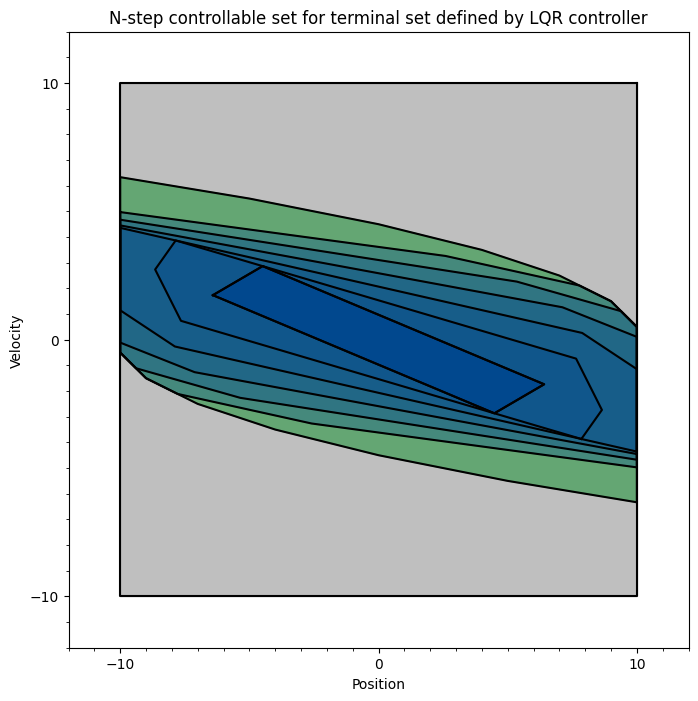

In [15]:
# Reuse the figure and axes created in the previous block
plt.figure(fig)  # Ensure you are referencing the correct figure
ctrlbSetsLQR=get_n_step_controllable_set(A, B, admissible_set_polytope, uCstrSet, 5, myLQRSet)

for S in ctrlbSetsLQR:
    S.plot(ax=ax,linestyle='-', color=KTH_blue, alpha=0.3)
ax.set_title('N-step controllable set for terminal set defined by LQR controller')
plt.show()


Let us repeat this exercise for $X_T=\{0\}$, i.e. when we drive the terminal state to the origin at the end of the planning horizon.

Converged with determinedness index 6.



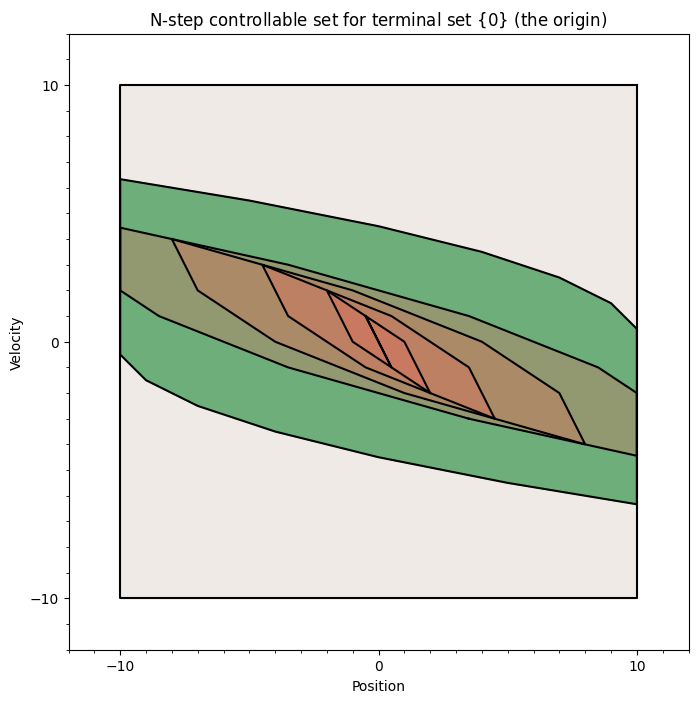

In [21]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Create the figure and axes


# Plot the polytope with customized color, line style, and opacity
patch = admissible_set_polytope.plot(ax=ax, color=KTH_sand, edgecolor='black', linestyle='-', alpha=0.8)

Cu=np.array([[1],[-1]])
cu=np.array([[1],[1]])
uCstrSet=Polytope(Cu,cu)
Cinf=control_invariant_set(A,B, admissible_set_polytope, uCstrSet)

Cinf.plot(ax=ax, color=KTH_green, alpha=0.8)

# Set the limits of the axes to encompass the full polytope
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize the x and y axis ticks
ax = plt.gca()  # Get the current axis

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Admissible set')

# Display the plot
fig=plt.gcf()

# Add the new set
zero_set(2).plot(ax=ax)

# Reuse the figure and axes created in the previous block
plt.figure(fig)  # Ensure you are referencing the correct figure
ctrlbSetsOrigin=get_n_step_controllable_set(A, B, admissible_set_polytope, uCstrSet, 5, zero_set(2))

for S in ctrlbSetsOrigin:
    S.plot(ax=ax,linestyle='-', alpha=0.3, color=KTH_brick)
    
ax.set_title(r'N-step controllable set for terminal set $\{0\}$ (the origin)')

plt.show()

This set is much smaller. It is not easy to see, so we will put the $5$-step controllable sets for the two terminal sets in the same figure.

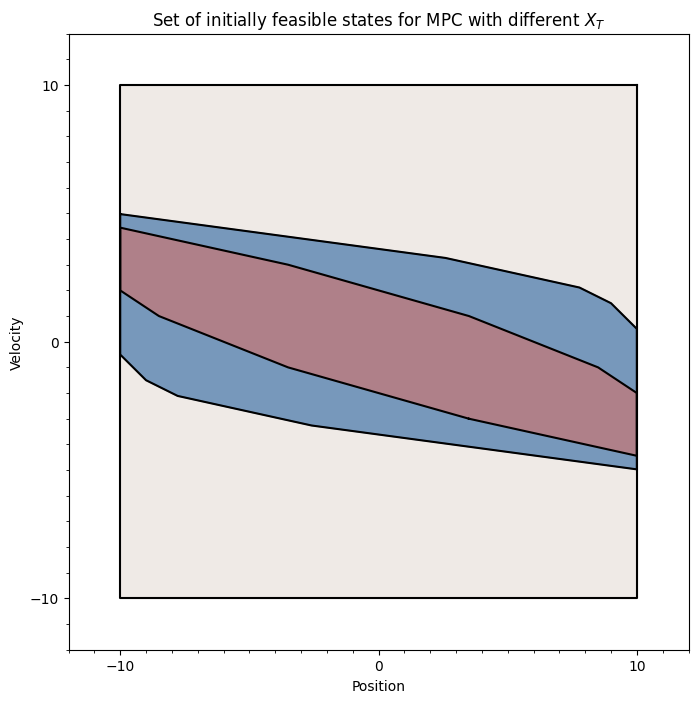

In [22]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))  # Create the figure and axes


# Plot the polytope with customized color, line style, and opacity
patch = admissible_set_polytope.plot(ax=ax, color=KTH_sand, edgecolor='black', linestyle='-', alpha=0.8)


# Set the limits of the axes to encompass the full polytope
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize the x and y axis ticks
ax = plt.gca()  # Get the current axis

# Set major ticks at -10 and 10
ax.set_xticks([-10, 0, 10])
ax.set_yticks([-10, 0, 10])

# Set minor ticks at every integer between -10 and 10
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Set of initially feasible states for MPC with different $X_T$')

ctrlbSetsLQR[5].plot(ax=ax, color=KTH_blue, alpha=0.5)
ctrlbSetsOrigin[5].plot(ax=ax, color=KTH_brick, alpha=0.5)

# Display the plot
fig=plt.gcf()

In [24]:
rSetsLQR=get_n_step_controllable_set(A, B, admissible_set_polytope, uCstrSet, 20, myLQRSet)
rSetsZero=get_n_step_controllable_set(A, B, admissible_set_polytope, uCstrSet, 20, zero_set(2))

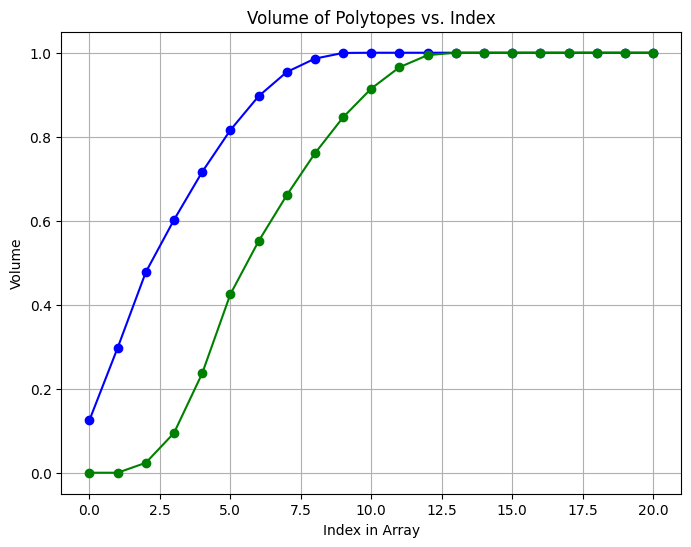

In [26]:
# Compute the volumes for each polytope in the array
volumesLQR = [polytope.volume()/Cinf.volume() for polytope in rSetsLQR]
volumesZero = [polytope.volume()/Cinf.volume() for polytope in rSetsZero]

# Create an array of indices (corresponding to polytope positions in the list)
indices = list(range(len(rSetsLQR)))

# Plot volumes against indices
plt.figure(figsize=(8, 6))
plt.plot(indices, volumesLQR, marker='o', linestyle='-', color='b')
plt.plot(indices, volumesZero, marker='o', linestyle='-', color='g')
plt.title('Volume of Polytopes vs. Index')
plt.xlabel('Index in Array')
plt.ylabel('Volume')
plt.grid(True)
plt.show()